https://www.kaggle.com/c/titanic

In [80]:
import math, os
import pandas as pd
from pandas_summary import DataFrameSummary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from fastai.structured import train_cats, proc_df, set_rf_samples, reset_rf_samples
%matplotlib inline

# 1 Load data

In [2]:
!ls data

gender_submission.csv  test.csv  train.csv


In [3]:
df_raw = pd.read_csv('data/train.csv')
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
DataFrameSummary(df_raw).summary()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,NaN,NaN,714,891,891,NaN,891,NaN,NaN
mean,446,0.383838,2.30864,NaN,NaN,29.6991,0.523008,0.381594,NaN,32.2042,NaN,NaN
std,257.354,0.486592,0.836071,NaN,NaN,14.5265,1.10274,0.806057,NaN,49.6934,NaN,NaN
min,1,0,1,NaN,NaN,0.42,0,0,NaN,0,NaN,NaN
25%,223.5,0,2,NaN,NaN,20.125,0,0,NaN,7.9104,NaN,NaN
50%,446,0,3,NaN,NaN,28,0,0,NaN,14.4542,NaN,NaN
75%,668.5,1,3,NaN,NaN,38,1,0,NaN,31,NaN,NaN
max,891,1,3,NaN,NaN,80,8,6,NaN,512.329,NaN,NaN
counts,891,891,891,891,891,714,891,891,891,891,204,889
uniques,891,2,3,891,2,88,7,7,681,248,147,3


# 2 Preprocess

In [7]:
train_cats(df_raw)

In [16]:
# df_raw.to_feather('data/df_raw')

In [18]:
df_raw = pd.read_feather('data/df_raw')
df, y, nas = proc_df(df_raw, 'Survived')

In [20]:
nas

{'Age': 28.0}

In [66]:
# split data
np.random.seed(15)
split = 0.2
n_split = int(len(df) * split)
idxs = np.random.permutation(len(df))
x_train, x_val = df.iloc[idxs[n_split:]], df.iloc[idxs[:n_split]]
y_train, y_val = y[idxs[n_split:]], y[idxs[:n_split]]

x_train.shape, x_val.shape

((713, 12), (178, 12))

# 3 Random Forest

In [78]:
def print_scores(m):
    print('Train score     : %.4f' % m.score(x_train, y_train))
    print('Validation score: %.4f' % m.score(x_val, y_val))
    if m.oob_score: print('OOB score       : %.4f' % m.oob_score_)

In [160]:
set_rf_samples(200)
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_scores(m)

Train score     : 0.9102
Validation score: 0.8539
OOB score       : 0.8163


In [165]:
feat_importance = pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
feat_importance

,cols,imp
3,Sex,0.188151
7,Ticket,0.146791
8,Fare,0.122541
2,Name,0.108810
0,PassengerId,0.107282
4,Age,0.097176
9,Cabin,0.074425
1,Pclass,0.044966
5,SibSp,0.035806
6,Parch,0.034521


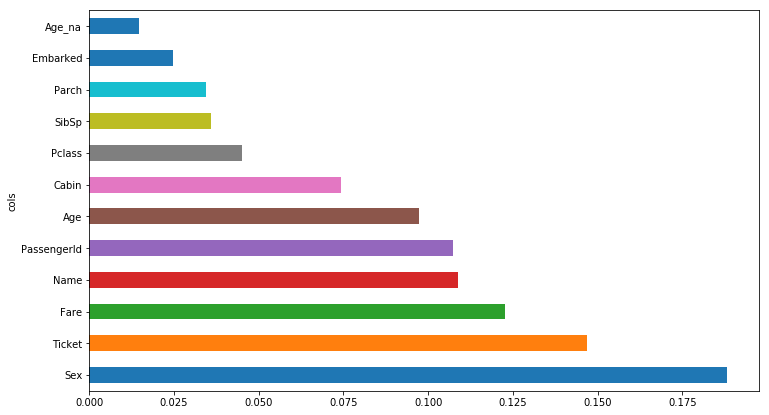

In [175]:
feat_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False);

# 4 With One hot encoding

In [278]:
df_raw = pd.read_feather('data/df_raw')
df, y, nas = proc_df(df_raw, 'Survived', max_n_cat=7)
df.drop('Sex_nan', axis=1, inplace=True)
np.random.seed(15)
split = 0.2
n_split = int(len(df) * split)
idxs = np.random.permutation(len(df))
x_train, x_val = df.iloc[idxs[n_split:]], df.iloc[idxs[:n_split]]
y_train, y_val = y[idxs[n_split:]], y[idxs[:n_split]]

x_train.shape, x_val.shape

((713, 16), (178, 16))

In [281]:
set_rf_samples(200)
m = RandomForestClassifier(n_estimators=50, min_samples_leaf=2, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_scores(m)

Train score     : 0.8864
Validation score: 0.8539
OOB score       : 0.8135


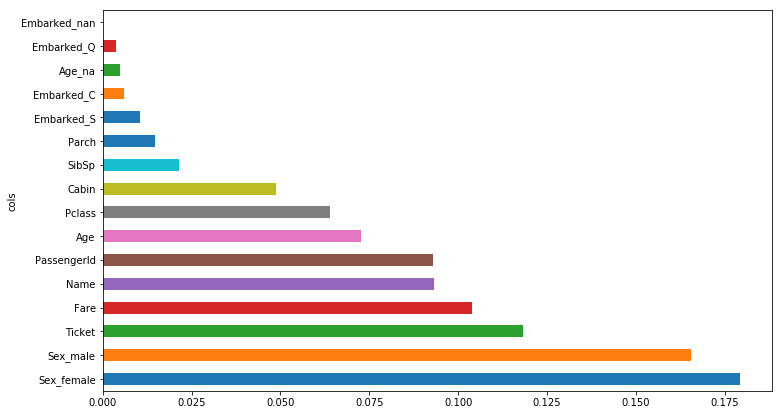

In [282]:
feat_importance = pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
feat_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False);

# 5 Check redundant features

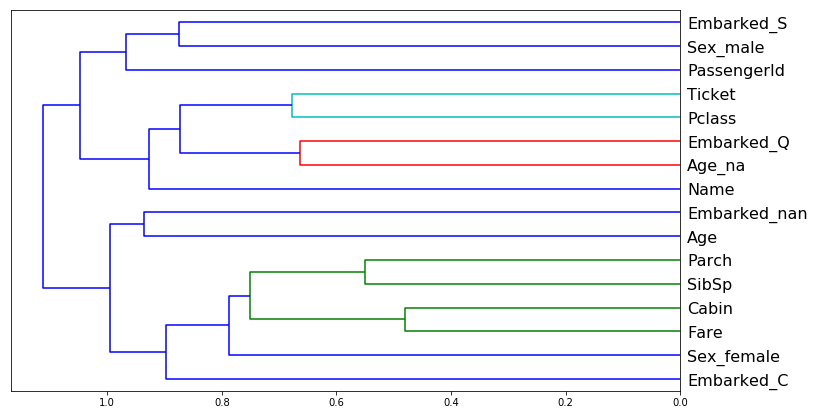

In [285]:
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df).correlation, 3)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(12,7))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

# 6 Partial dependence

In [372]:
pdp.pdp_plot??

In [383]:
from pdpbox import pdp

sample = df.sample(300)

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, sample, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None, n_cluster_centers=clusters)

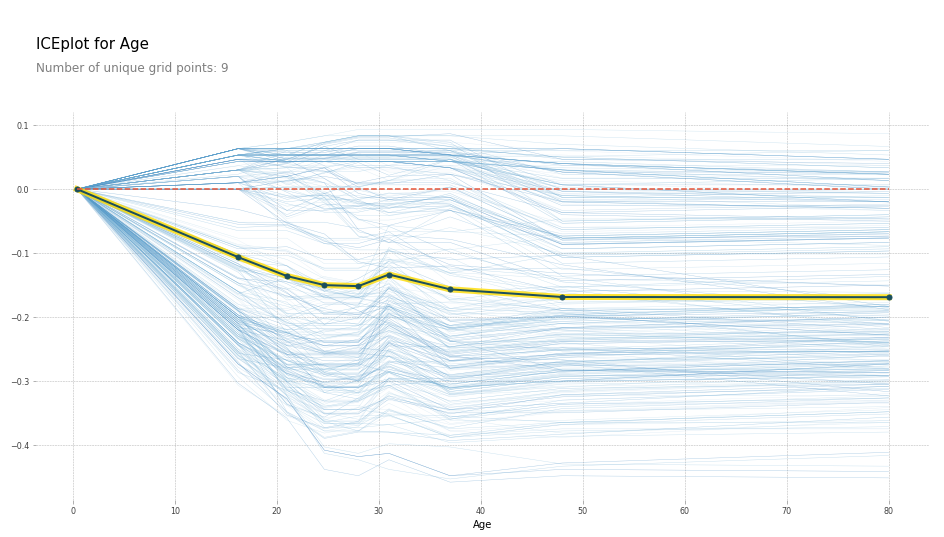

In [384]:
plot_pdp('Age')

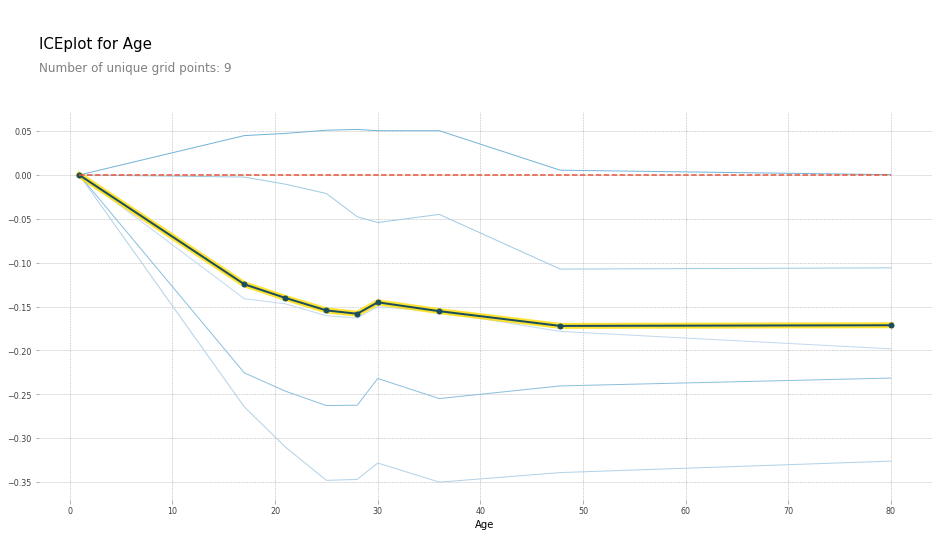

In [305]:
plot_pdp('Age', clusters=5)

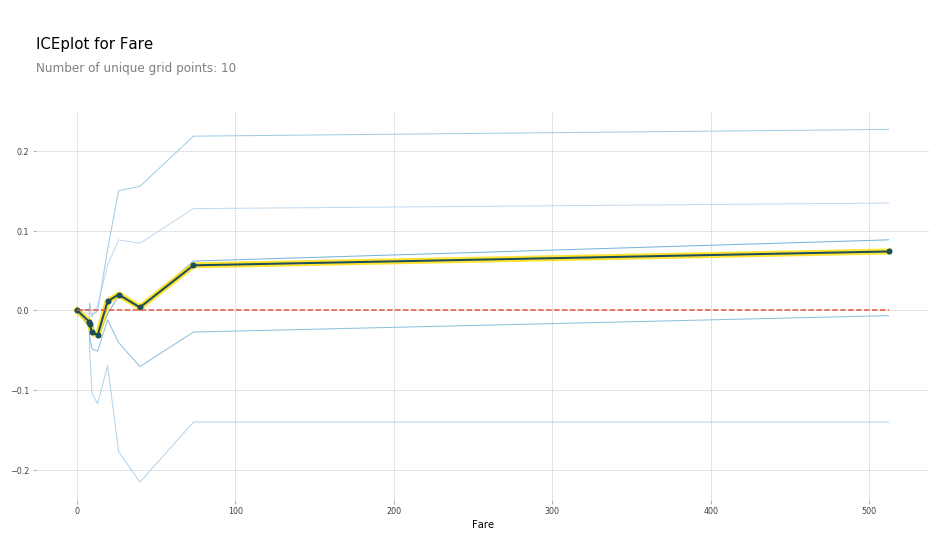

In [312]:
plot_pdp('Fare', clusters=5)

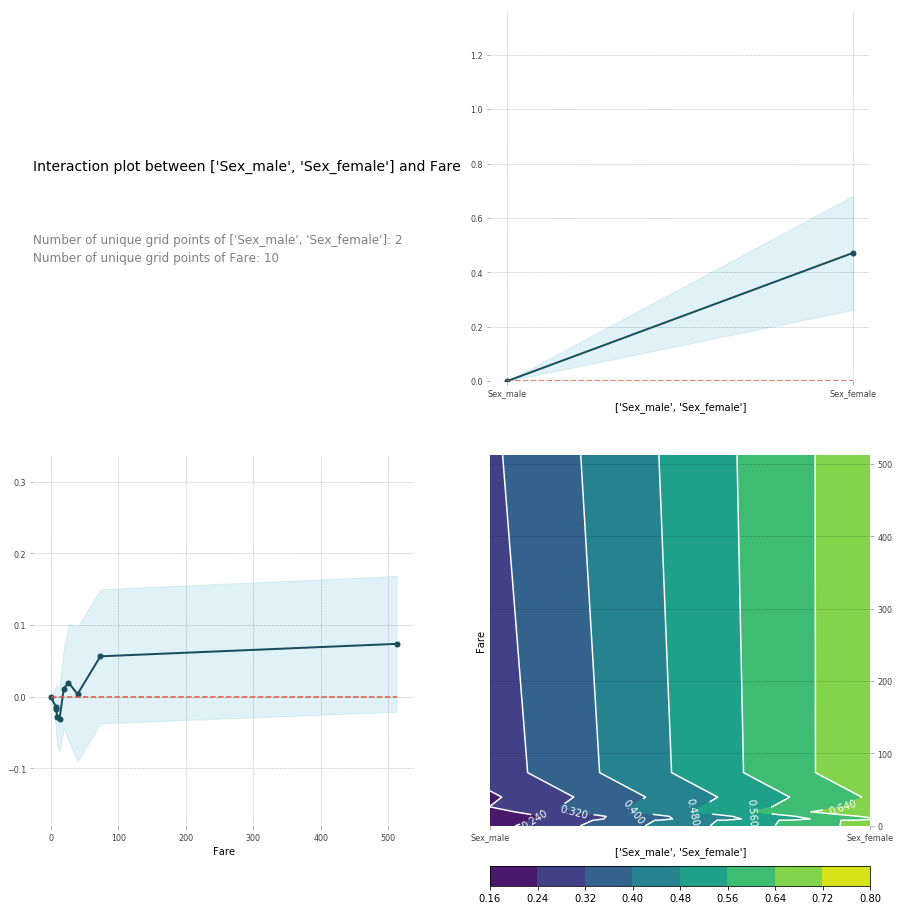

In [318]:
feats = [['Sex_male', 'Sex_female'], 'Fare']
p = pdp.pdp_interact(m, sample, feats)
pdp.pdp_interact_plot(p, feats)

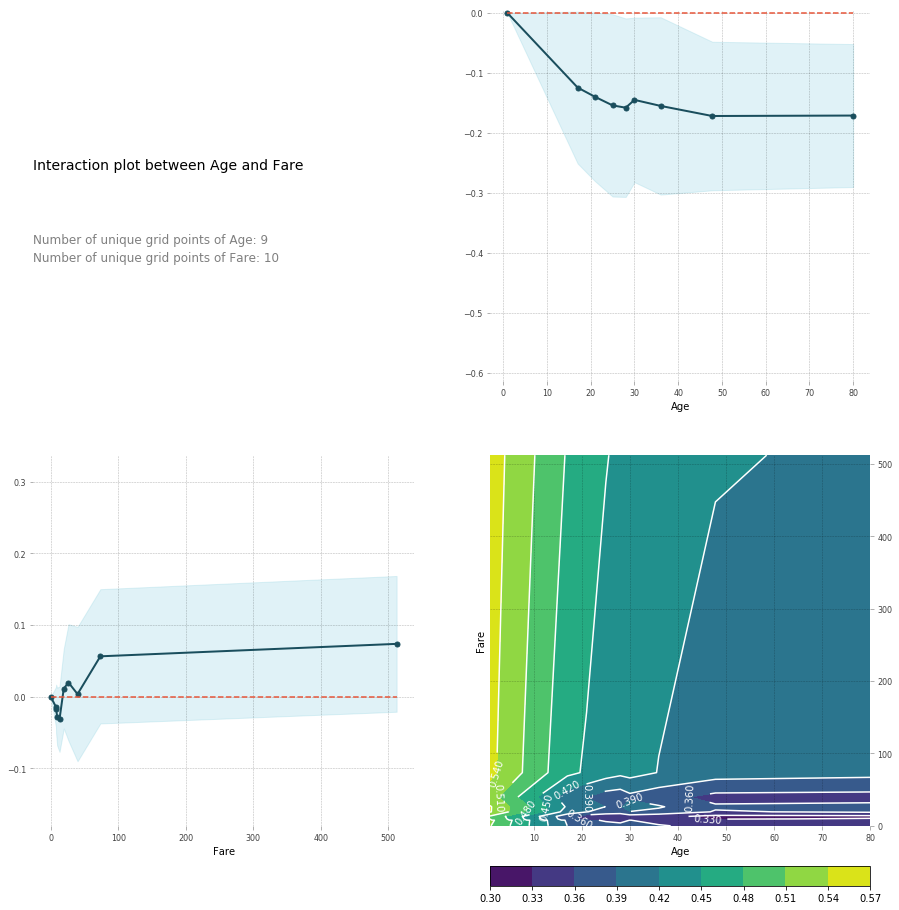

In [316]:
feats = ['Age', 'Fare']
p = pdp.pdp_interact(m, sample, feats)
pdp.pdp_interact_plot(p, feats)

# 7 Tree interpreter

In [319]:
from treeinterpreter import treeinterpreter as ti

In [405]:
idx = np.random.choice(len(x_val))
print(idx)
row = x_val.values[None,idx]; row, y_val[idx]

130


(array([[582, 1, 806, 39.0, 1, 1, 84, 110.8833, 76, False, 1, 0, 1, 0, 0, 0]], dtype=object),
 1)

In [406]:
prediction, bias, contributions = ti.predict(m, row)
prediction[0][1], bias[0][1]

(0.98999999999999999, 0.37169999999999992)

In [407]:
idxs = np.argsort(contributions[0,:,1])
[o for o in zip(df.columns[idxs], df.iloc[0][idxs], contributions[0,idxs,1])]

[('Age_na', False, 0.0),
 ('Embarked_C', 0, 0.0),
 ('Embarked_nan', 0, 0.0),
 ('Age', 22.0, 4.5175008265663233e-05),
 ('Embarked_Q', 0, 0.0004081632653061229),
 ('Parch', 0, 0.0021741605881472224),
 ('Embarked_S', 1, 0.0027972027972027959),
 ('SibSp', 1, 0.0035464193391012565),
 ('Name', 109, 0.0059300235941825985),
 ('PassengerId', 1, 0.011826640998837035),
 ('Cabin', 0, 0.031092352168032137),
 ('Ticket', 524, 0.033624614442380844),
 ('Fare', 7.25, 0.054456572018614723),
 ('Pclass', 3, 0.10549636215097653),
 ('Sex_female', 0, 0.18024384022318571),
 ('Sex_male', 1, 0.18665847340576738)]

In [408]:
contributions[0,idxs,1].sum()

0.61829999999999996

# 8 Extrapolation

In [435]:
df_ext = df.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:-200] = 0
x, y, _ = proc_df(df_ext, 'is_valid')

In [437]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_scores(m)

Train score     : 0.5764
Validation score: 0.4831
OOB score       : 0.9989


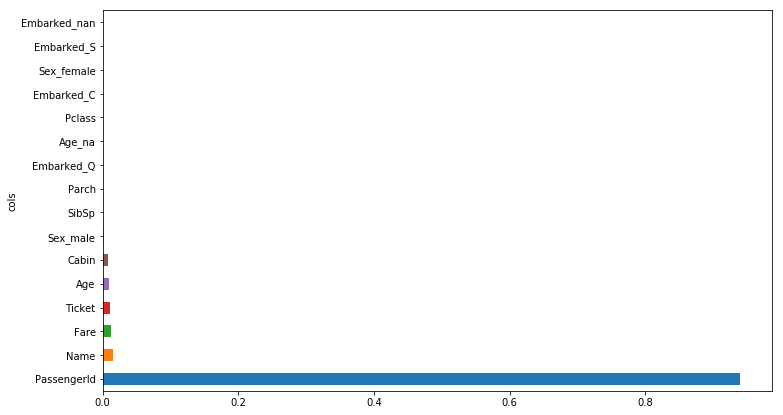

In [438]:
feat_importance = pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
feat_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False);

0.774410774411


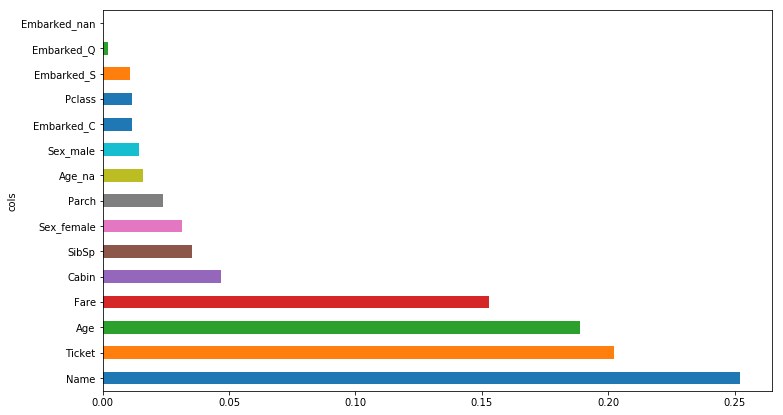

In [451]:
x.drop('PassengerId', axis=1, inplace=True)

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print(m.oob_score_)

feat_importance = pd.DataFrame({'cols':x.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
feat_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False);

0.774410774411


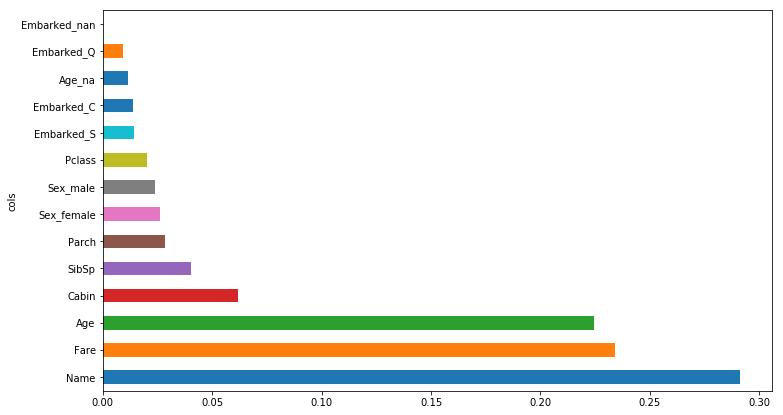

In [452]:
x.drop('Ticket', axis=1, inplace=True)

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print(m.oob_score_)

feat_importance = pd.DataFrame({'cols':x.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
feat_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False);

# Final

In [453]:
df_raw = pd.read_feather('data/df_raw')
df, y, nas = proc_df(df_raw, 'Survived', max_n_cat=7)
df.drop(['Sex_nan', 'PassengerId', 'Ticket'], axis=1, inplace=True)
np.random.seed(15)
split = 0.2
n_split = int(len(df) * split)
idxs = np.random.permutation(len(df))
x_train, x_val = df.iloc[idxs[n_split:]], df.iloc[idxs[:n_split]]
y_train, y_val = y[idxs[n_split:]], y[idxs[:n_split]]

x_train.shape, x_val.shape

((713, 14), (178, 14))

In [467]:
reset_rf_samples()
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_scores(m)

Train score     : 0.9257
Validation score: 0.8315
OOB score       : 0.8219


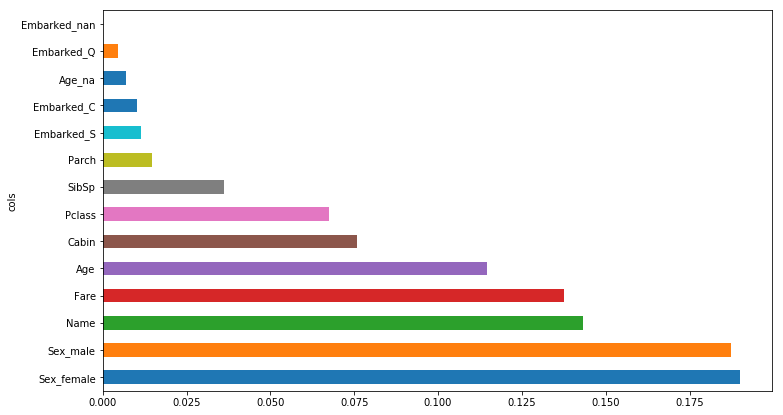

In [468]:
feat_importance = pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
feat_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False);